In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import json
import os
import cv2
import matplotlib.pyplot as plt
import shutil

##### import coco anotations

In [6]:
path = ''

In [8]:
!unzip "{path}"coco_data.zip -d "/content/coco-data"

Archive:  /content/drive/Shareddrives/P&I/Data & ML/PV&rooftop_project/coco_data.zip
  inflating: /content/coco-data/coco_data.json  
  inflating: /content/coco-data/__MACOSX/._coco_data.json  


In [9]:
f = open('/content/coco-data/coco_data.json')
coco_data = json.load(f)
f.close()
print(type(coco_data), len(coco_data))
coco_data.keys()

<class 'dict'> 6


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories', 'tag_categories'])

##### change class ids to 0-n

In [10]:
coco_data['categories']

[{'id': 0, 'name': 'Wintergarten ceiling', 'supercategory': 'root'},
 {'id': 1, 'name': 'PV', 'supercategory': 'root'},
 {'id': 2, 'name': 'Roof type', 'supercategory': 'root'},
 {'id': 3, 'name': 'Roof windows', 'supercategory': 'root'},
 {'id': 4, 'name': 'Dormers', 'supercategory': 'root'},
 {'id': 5, 'name': 'Thermal panels', 'supercategory': 'root'},
 {'id': 6, 'name': 'PV_Negative', 'supercategory': 'root'}]

##### create folder with the images

In [25]:
!cp "{path}"/images.zip "/content"
# !mkdir "/content/images"
!unzip /content/images.zip -d /content


Archive:  /content/images.zip
   creating: /content/images/
  inflating: /content/__MACOSX/._images  
  inflating: /content/images/348.png  
  inflating: /content/__MACOSX/images/._348.png  
  inflating: /content/images/412.png  
  inflating: /content/__MACOSX/images/._412.png  
  inflating: /content/images/374.png  
  inflating: /content/__MACOSX/images/._374.png  
  inflating: /content/images/360.png  
  inflating: /content/__MACOSX/images/._360.png  
  inflating: /content/images/406.png  
  inflating: /content/__MACOSX/images/._406.png  
  inflating: /content/images/638.png  
  inflating: /content/__MACOSX/images/._638.png  
  inflating: /content/images/176.png  
  inflating: /content/__MACOSX/images/._176.png  
  inflating: /content/images/88.png  
  inflating: /content/__MACOSX/images/._88.png  
  inflating: /content/images/610.png  
  inflating: /content/__MACOSX/images/._610.png  
  inflating: /content/images/604.png  
  inflating: /content/__MACOSX/images/._604.png  
  inflatin

##### convert coco to yolo: https://medium.com/red-buffer/converting-a-custom-dataset-from-coco-format-to-yolo-format-6d98a4fd43fc

In [26]:
input_path = '/content/images/'
output_path = '/content/yolo_data/'

!mkdir yolo_data
!mkdir yolo_data/images
!mkdir yolo_data/labels

mkdir: cannot create directory ‘yolo_data’: File exists
mkdir: cannot create directory ‘yolo_data/images’: File exists
mkdir: cannot create directory ‘yolo_data/labels’: File exists


In [27]:
len(os.listdir('/content/images'))

1000

In [28]:
file_names = []

def load_images_from_folder(input_path, output_path):
  count = 0
  for filename in os.listdir(input_path):
        source = os.path.join(input_path,filename)

        destination = f"{output_path}images/{filename}"

        try:
            shutil.copy(source, destination)
            print("File copied successfully.")
        # If source and destination are same
        except shutil.SameFileError:
            print("Source and destination represents the same file.")

        file_names.append(filename)
        count += 1

load_images_from_folder(input_path, output_path)

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

In [29]:
def get_img_ann(image_id):
    img_ann = []
    isFound = False
    for ann in coco_data['annotations']:
        if ann['image_id'] == image_id:
            img_ann.append(ann)
            isFound = True
    if isFound:
        return img_ann
    else:
        return None

def get_img(filename):
  for img in coco_data['images']:
    if img['file_name'] == filename:
      return img

In [30]:
count = 0

for filename in file_names:
  # Extracting image
  img = get_img(filename)
  img_id = img['id']
  img_w = img['width']
  img_h = img['height']

  # Get Annotations for this image
  img_ann = get_img_ann(img_id)

  if img_ann:
    # Opening file for current image
    imgname = filename.split(".")[0]
    file_object = open(f"{output_path}labels/{imgname}.txt", "a")

    for ann in img_ann:
      current_category = ann['category_id'] # - 1 # As yolo format labels start from 0
      current_bbox = ann['bbox']
      x = current_bbox[0]
      y = current_bbox[1]
      w = current_bbox[2]
      h = current_bbox[3]

      # Finding midpoints
      x_centre = (x + (x+w))/2
      y_centre = (y + (y+h))/2

      # Normalization
      x_centre = x_centre / img_w
      y_centre = y_centre / img_h
      w = w / img_w
      h = h / img_h

      # Limiting upto fix number of decimal places
      x_centre = format(x_centre, '.3f')
      y_centre = format(y_centre, '.3f')
      w = format(w, '.3f')
      h = format(h, '.3f')

      # Writing current object
      file_object.write(f"{current_category} {x_centre} {y_centre} {w} {h}\n")

    file_object.close()
    count += 1  # This should be outside the if img_ann block.

In [31]:
!zip -r yolo_data.zip yolo_data/

  adding: yolo_data/ (stored 0%)
  adding: yolo_data/labels/ (stored 0%)
  adding: yolo_data/labels/111.txt (deflated 63%)
  adding: yolo_data/labels/831.txt (deflated 64%)
  adding: yolo_data/labels/998.txt (deflated 23%)
  adding: yolo_data/labels/699.txt (deflated 55%)
  adding: yolo_data/labels/709.txt (deflated 59%)
  adding: yolo_data/labels/150.txt (deflated 62%)
  adding: yolo_data/labels/644.txt (deflated 60%)
  adding: yolo_data/labels/557.txt (deflated 55%)
  adding: yolo_data/labels/674.txt (deflated 53%)
  adding: yolo_data/labels/502.txt (deflated 55%)
  adding: yolo_data/labels/162.txt (deflated 61%)
  adding: yolo_data/labels/231.txt (deflated 60%)
  adding: yolo_data/labels/424.txt (deflated 49%)
  adding: yolo_data/labels/786.txt (deflated 64%)
  adding: yolo_data/labels/665.txt (deflated 60%)
  adding: yolo_data/labels/542.txt (deflated 53%)
  adding: yolo_data/labels/493.txt (deflated 58%)
  adding: yolo_data/labels/540.txt (deflated 55%)
  adding: yolo_data/labels/

In [32]:
def load_image_and_annotation(image_file, annotation_file):
    # Load the image
    image = cv2.imread(image_file)

    # Load the annotation
    with open(annotation_file, "r") as f:
        lines = f.readlines()
    annotation = []
    for line in lines:
        data = line.strip().split(" ")
        class_id = int(data[0])
        x_center = float(data[1])
        y_center = float(data[2])
        width = float(data[3])
        height = float(data[4])

        # Calculate the coordinates of the bounding box
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])

        annotation.append((class_id, x_min, y_min, x_max, y_max))

    return image, np.array(annotation)

def show_image_with_annotations(image, annotations):
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for annotation in annotations:
        class_id, x_min, y_min, x_max, y_max = annotation
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                           linewidth=2, edgecolor='r', facecolor='none'))
    plt.axis("off")
    plt.show()

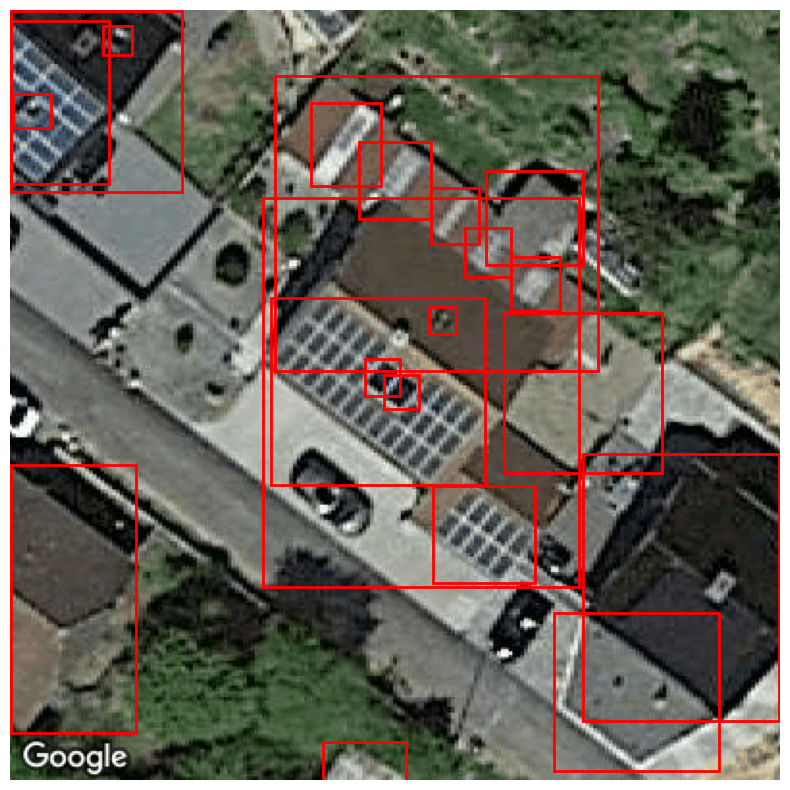

In [33]:
image, annotations = load_image_and_annotation('/content/yolo_data/images/510.png', '/content/yolo_data/labels/510.txt')
show_image_with_annotations(image, annotations)
